# Generative Adversarial Nets
#### Ian J. Goodfellow et al _Universite de Montreal
In Adversarial training procedure two models are trained together. The generative model, G, that estimates the data distribution and the discriminative model, D, that determines if a given sample has come from the dataset or artificially generated. G is evolved into making artificially generated samples that are with higher probability mistaken by the D model as coming from true data distribution.
One nice property of GANs is that the generator is not directly updated with data examples, but by the gradients coming through the discriminator.
Here we will make a conditional generative model p(x|c) by adding some class label c as input to both G and D.

In [11]:
# Imports
%reload_ext autoreload
%autoreload 1

import os, sys
sys.path.append('../')

from IPython.display import Image
from tools_train import get_train_params, OneHot, vis_square
from tools_general import tf, np

### Network defenitions

In [2]:
# define networks
from tools_networks import deconv, conv, dense, clipped_crossentropy, dropout

def create_gan_G(z, labels, is_training, Cout=1, trainable=True, reuse=False, networktype='ganG'):
    '''input : batchsize * 100 and labels to make the generator conditional
        output: batchsize * 28 * 28 * 1'''
    with tf.variable_scope(networktype, reuse=reuse):
        z = tf.concat(axis=-1, values=[z, labels])
        Gz = dense(z, is_training, Dout=2 * 2 * 512, act='ReLu', useBN=True, name='dense1')
        Gz = dense(Gz, is_training, Dout=4 * 4 * 1024, act='ReLu', useBN=True, name='dense2')
        Gz = tf.reshape(Gz, shape=[-1, 4, 4, 1024])  # 4
        Gz = deconv(Gz, is_training, kernel_w=5, stride=2, Cout=512, trainable=trainable, act='reLu', useBN=True, name='deconv1')  # 11
        Gz = deconv(Gz, is_training, kernel_w=5, stride=2, Cout=256, trainable=trainable, act='reLu', useBN=True, name='deconv2')  # 25
        Gz = deconv(Gz, is_training, kernel_w=4, stride=1, Cout=1, act=None, useBN=False, name='deconv3')  # 28
        Gz = tf.nn.sigmoid(Gz)
    return Gz

def create_gan_D(xz, labels, is_training, trainable=True, reuse=False, networktype='ganD'):
    with tf.variable_scope(networktype, reuse=reuse):
        
        labels_reshaped = tf.reshape(labels, [-1, 1, 1, 10])
        a = tf.ones([tf.shape(xz)[0], 28, 28, 10])
        xz = tf.concat([xz, labels_reshaped * a], axis = 3)

        Dxz = conv(xz, is_training, kernel_w=5, stride=2, Cout=512, trainable=trainable, act='lrelu', useBN=False, name='conv1')  # 12
        #Dxz = dropout(Dxz, is_training, p=0.8)
        Dxz = conv(Dxz, is_training, kernel_w=5, stride=2, Cout=1024, trainable=trainable, act='lrelu', useBN=True, name='conv2')  # 4
        #Dxz = dropout(Dxz, is_training, p=0.8)
        Dxz = conv(Dxz, is_training, kernel_w=2, stride=2, Cout=1024, trainable=trainable, act='lrelu', useBN=True, name='conv3')  # 2
        Dxz = conv(Dxz, is_training, kernel_w=2, stride=2, Cout=1, trainable=trainable, act='lrelu', useBN=True, name='conv4')  # 2
               
        Dxz = tf.nn.sigmoid(Dxz)
    return Dxz

def create_gan_trainer(base_lr=1e-4, networktype='gan'):
    '''Train a Generative Adversarial Network'''
    # with tf.name_scope('train_%s' % networktype): 
    is_training = tf.placeholder(tf.bool, [], 'is_training')

    inZ = tf.placeholder(tf.float32, [None, 100])
    inL = tf.placeholder(tf.float32, [None, 10])  # we want to condition the generated output on the input label
    inX = tf.placeholder(tf.float32, [None, 28, 28, 1])

    Gz = create_gan_G(inZ, inL, is_training, Cout=1, trainable=True, reuse=False, networktype=networktype + '_G') 

    DGz = create_gan_D(Gz, inL, is_training, trainable=True, reuse=False, networktype=networktype + '_D')
    Dx = create_gan_D(inX, inL, is_training, trainable=True, reuse=True, networktype=networktype + '_D')
    
    ganG_var_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope=networktype + '_G')
    #print(len(ganG_var_list), [var.name for var in ganG_var_list])

    ganD_var_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope=networktype + '_D')
    #print(len(ganD_var_list), [var.name for var in ganD_var_list])
          
    Gscore = clipped_crossentropy(DGz, tf.ones_like(DGz))
    Dscore = clipped_crossentropy(DGz, tf.zeros_like(DGz)) + clipped_crossentropy(Dx, tf.ones_like(Dx))
    
    Gtrain = tf.train.AdamOptimizer(learning_rate=base_lr, beta1=0.45).minimize(Gscore, var_list=ganG_var_list)
    Dtrain = tf.train.AdamOptimizer(learning_rate=base_lr, beta1=0.45).minimize(Dscore, var_list=ganD_var_list)
    
    return Gtrain, Dtrain, Gscore, Dscore, is_training, inZ, inX, inL, Gz

In [3]:
# define parameters
networktype = 'ganMNIST'

batch_size = 128
base_lr = 0.0002  # 1e-4
epochs = 10

data_dir = '../data/'
work_dir = '../results/%s/20170705/' %networktype

if not os.path.exists(work_dir): os.makedirs(work_dir)

data, max_iter, test_iter, test_int, disp_int = get_train_params(data_dir, batch_size, epochs, networktype=networktype)

Extracting ../data/train-images-idx3-ubyte.gz
Extracting ../data/train-labels-idx1-ubyte.gz
Extracting ../data/t10k-images-idx3-ubyte.gz
Extracting ../data/t10k-labels-idx1-ubyte.gz
Trainset size: 55000 Testset_size: 10000


### Adversarial Training

In [4]:
tf.reset_default_graph() 
with tf.Session() as sess:

    Gtrain, Dtrain, Gscore, Dscore, is_training, inZ, inX, inL, Gz = create_gan_trainer(base_lr, networktype=networktype)
    tf.global_variables_initializer().run()

    var_list = [var for var in tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES) 
                if (networktype.lower() in var.name.lower()) and ('adam' not in var.name.lower())]  
    saver = tf.train.Saver(var_list=var_list, max_to_keep = 1000)
    # saver.restore(sess, best_ganMNIST_model)  

    Z_test = np.random.uniform(size=[batch_size, 100], low=-1., high=1.).astype(np.float32)
    labels_test = OneHot(np.random.randint(10, size=[batch_size]), n=10)    

    k = 1

    for it in range(1, max_iter):
        Z = np.random.uniform(size=[batch_size, 100], low=-1., high=1.).astype(np.float32)
        X, labels = data.train.next_batch(batch_size)

        for itD in range(k):
            cur_Gscore, _ = sess.run([Gscore, Gtrain], feed_dict={inZ:Z, inL:labels, is_training:True})

        cur_Dscore, _ = sess.run([Dscore, Dtrain], feed_dict={inX:X, inZ:Z, inL:labels, is_training:True})

        if it % disp_int == 0:
            Gz_sample = sess.run(Gz, feed_dict={inZ: Z_test, inL: labels_test, is_training:False})
            vis_square(Gz_sample[:121], [11, 11], save_path=work_dir + 'Iter_%d.jpg' % it)
            saver.save(sess, work_dir + "%4d_model.ckpt" % it)
            if ('cur_Dscore' in vars()) and ('cur_Gscore' in vars()):
                print("Iteration #%4d, Train Gscore = %f, Dscore=%f" % (it, cur_Gscore, cur_Dscore))

Iteration # 214, Train Gscore = 0.463272, Dscore=1.461864
Iteration # 428, Train Gscore = 0.465792, Dscore=1.458886
Iteration # 642, Train Gscore = 0.466194, Dscore=1.458497
Iteration # 856, Train Gscore = 0.462757, Dscore=1.460288
Iteration #1070, Train Gscore = 0.467763, Dscore=1.456861
Iteration #1284, Train Gscore = 0.468258, Dscore=1.455687
Iteration #1498, Train Gscore = 0.464856, Dscore=1.459118
Iteration #1712, Train Gscore = 0.466211, Dscore=1.458000
Iteration #1926, Train Gscore = 0.467717, Dscore=1.456834
Iteration #2140, Train Gscore = 0.464176, Dscore=1.460118
Iteration #2354, Train Gscore = 0.463220, Dscore=1.460641


what if we make our noise gaussian (and make some samples more frquent)?

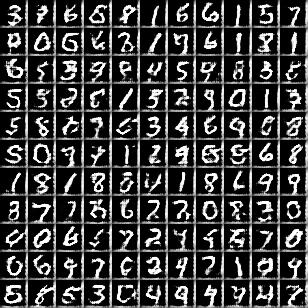

In [6]:
best_iter = 6420#visually selected
best_img = work_dir + 'Iter_%d.jpg' %best_iter
best_ganMNIST_model = work_dir + "%.3d_model.ckpt" % best_iter
Image(filename=best_img)

### Demos
Create demo networks and restore weights

In [7]:
tf.reset_default_graph() 
demo_sess = tf.InteractiveSession()

is_training = tf.placeholder(tf.bool, [], 'is_training')

inZ = tf.placeholder(tf.float32, [None, 100])
inL = tf.placeholder(tf.float32, [None, 10])
inX = tf.placeholder(tf.float32, [None, 28, 28, 1])

Gz = create_gan_G(inZ, inL, is_training, Cout=1, trainable=True, reuse=False, networktype=networktype + '_G') 

DGz = create_gan_D(Gz, inL, is_training, trainable=True, reuse=False, networktype=networktype + '_D')
    
tf.global_variables_initializer().run()

ganG_var_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope=networktype + '_G')
saver = tf.train.Saver(var_list=ganG_var_list)
saver.restore(demo_sess, best_ganMNIST_model) 

INFO:tensorflow:Restoring parameters from ../results/ganMNIST/20170705/6420_model.ckpt


#### 1) generate bag of numbers

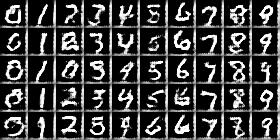

In [9]:
batch_size = 50
desired_number = 0
Z_test = np.random.uniform(size=[batch_size, 100], low=-1., high=1.).astype(np.float32)
labels_test = OneHot(np.repeat([[0,1,2,3,4,5,6,7,8,9]],batch_size//10,axis=0))
#labels_test = OneHot(np.repeat([[0,1,0,1,0,1,0,1,0,1]],batch_size//10,axis=0))

Gz_sample = demo_sess.run(Gz, feed_dict={inZ: Z_test, inL: labels_test, is_training:False})
img = vis_square(Gz_sample, [batch_size//10, 10],save_path=work_dir + 'test.jpg')
Image(filename=work_dir + 'test.jpg')

### Interpolation in z space